In [14]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import sys
import random


from gym import spaces, logger
from gym.utils import seeding

# custom environment and agent classes
from cartpole_custom import *

In [17]:
# random behavior
env = CustomCartPoleEnv()
env.reset()

for _ in range(5):
    env.reset()
    done = False
    step_counter = 0
    sum_rewards = 0
    for _ in range(50):
        env.render()
        state, reward, done, info = env.step(env.action_space.sample()) # take a random action
        
env.close()


In [ ]:
# # collect some statistics on states visited under random policy
# # used for subsequent discretization of state space for tabular Q learning
# nmc = 10000
# saved_states = []

# for i in range(nmc):
#     env.reset()
#     done = False
#     step_counter = 0
#     sum_rewards = 0
#     while not done:
#         state, reward, done, info = env.step(env.action_space.sample()) # take a random action
#         step_counter += 1
#         sum_rewards += reward
#         saved_states.append(state)


# n_points = 2
# q = np.linspace(0,1,n_points*2)
# cutpoints = np.quantile(saved_states, q, axis=0)
# cutpoints = np.insert(cutpoints, n_points, 0, 0) 

# q = np.linspace(0.5/n_points, 1, n_points)
# cut_pos = np.quantile(np.abs(saved_states), q, axis=0)
# cutpoints = np.concatenate((np.flip(-cut_pos,0), cut_pos), axis=0)
# cutpoints = np.insert(cutpoints, n_points, 0, 0) 
# print(cutpoints)

In [18]:
# cutpoints = np.array([[-2.4, -0.075 ,-0.035, -0.01, 0, 0.01, 0.035, 0.075, 2.4],
#                       [-3.9, -0.58, -0.24, -0.045, 0, 0.045, 0.24, 0.58, 3.9],
#                       [-0.27, -0.11, -0.047, -0.013, 0, 0.013, 0.047, 0.11, 0.27],
#                       [-3.68, -0.89, -0.44, -0.12, 0, 0.12, 0.44, 0.89, 3.68]]).transpose()


# sparser state-space representation
cutpoints = np.array([[-1.4, -0.021, 0, 0.021, 1.4],
                      [-2.9, -0.18, 0, 0.18, 2.9],
                      [-0.26, -0.027, 0, 0.027, 0.26],
                      [-3.34, -0.27, 0, 0.27, 3.34]]).transpose()

print(cutpoints)

[[-1.4   -2.9   -0.26  -3.34 ]
 [-0.021 -0.18  -0.027 -0.27 ]
 [ 0.     0.     0.     0.   ]
 [ 0.021  0.18   0.027  0.27 ]
 [ 1.4    2.9    0.26   3.34 ]]


In [33]:
###
# SARSA(lambda) learning
###

env = CustomCartPoleEnv()
env.reset()
agent = CartPoleSarsaLambdaLearner(env, cutpoints)

alpha_decay = 0.995
alpha_min = 0.001
alpha = 0.2
lam = 0.8
gam = 0.99


# run some steps
num_episodes = 500
survived = np.zeros(num_episodes)

for i in range(num_episodes):
    eps = 1.0/(1.0+i)
    state = env.reset()
    done = False
    step_counter = 0
    sum_rewards = 0
    
    # reset the eligibility trace for this episode
    agent.resetZ()
    
    # choose initial action according to epsilon-greedy version of the policy
    action = agent.choose_action(state, eps=eps)
    
    while not done and step_counter < 2500:
        
        # we know the SA in SARSA from previous step
        # now get RSA (reward, next_state, next_action)
        next_state, reward, done, info = env.step(action)
        next_action = agent.choose_action(next_state, eps=eps)
        
        # update the Q function
        SARSA = [state, action, reward, next_state, next_action]
        agent.update_Q(SARSA, alpha = alpha, gamma = gam, lam=lam)
        
        # bookkeeping
        state = next_state
        action = next_action
        step_counter += 1
        sum_rewards += reward

    survived[i] = step_counter
    
    # decay alpha
    alpha = max(alpha_min, alpha*alpha_decay)


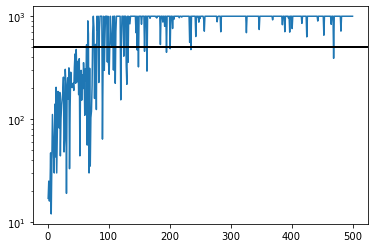

In [32]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(range(1, num_episodes+1), survived)
ax.axhline(500, color='black', lw=2)

In [ ]:
agent.show_n_episodes(env, 3)

In [ ]:
###
# Q learning
###

env = CustomCartPoleEnv()
env.reset()
agent = CartPoleQLearner(env, cutpoints)

alpha_decay = 0.999
alpha_min = 0.001
alpha = 0.2
gam = 0.999


# run some steps
num_episodes = 500
survived = np.zeros(num_episodes)

for i in range(num_episodes):
    eps = max(0.1, 1.0/(1.0+i))
    state = env.reset()
    done = False
    step_counter = 0
    sum_rewards = 0
    
    while not done and step_counter < 500:
        action = agent.choose_action(state, eps=eps)
        next_state, reward, done, info = env.step(action)
    
        agent.update_Q([state, action, reward, next_state], alpha = alpha, gamma = gam)
        step_counter += 1
        sum_rewards += reward
        state = next_state
    
    survived[i] = step_counter
    # decay alpha
    alpha = max(alpha_min, alpha*alpha_decay)

print(alpha)
env.close()

In [ ]:
fig, ax = plt.subplots() 
ax.plot(range(1, num_episodes+1), survived) 

In [ ]:
agent.show_n_episodes(env, 3)

In [ ]:
###
# Monte Carlo learning
###

env = CustomCartPoleEnv()
env.reset()
agent = CartPoleMCLearner(env, cutpoints)

alpha_decay = 0.995
alpha_min = 0.001
alpha = 0.2
gam = 0.99


# run some steps
num_episodes = 2500
survived = np.zeros(num_episodes)

for i in range(num_episodes):
    eps = max(0.1, 1.0/(1.0+i))
    state = env.reset()
    done = False
    step_counter = 0
    sum_rewards = 0
    episode = []
    
    while not done and step_counter < 500:
        
        action = agent.choose_action(state, eps=eps)
        next_state, reward, done, info = env.step(action)
        step_counter += 1
        sum_rewards += reward
        episode.append([state, action, reward, next_state])
        state = next_state
        
        
    # decay alpha
    survived[i] = step_counter
    agent.update_Q(episode, alpha = alpha, gamma = gam)
    alpha = max(alpha_min, alpha*alpha_decay)

print(alpha)
env.close()

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1, num_episodes+1), moving_average(survived, 5)) 

In [ ]:
agent.show_n_episodes(env, 3)